In [22]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from Train_policy_func import PolicyContinuous, device
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores
from PPO import ppo_update, RolloutBuffer, evaluate_policy

# Training loop for OPPO
from OPPO_cont import baseline_CartPole_V0, baseline_MountainCar_continuous, baseline_0, OPPO_update
# from OPPO import baseline_1, baseline_CartPole_v0_Fla

  0%|          | 0/200 [00:00<?, ?it/s]

Episode 20 	 Average Score over the last 20 episodes: -107.2
Episode 40 	 Average Score over the last 20 episodes: -113.4
Episode 60 	 Average Score over the last 20 episodes: -129.9
Episode 80 	 Average Score over the last 20 episodes: -153.2
Episode 100 	 Average Score over the last 20 episodes: -169.9
Episode 120 	 Average Score over the last 20 episodes: -179.9
Episode 140 	 Average Score over the last 20 episodes: -221.8
Episode 160 	 Average Score over the last 20 episodes: -247.0
Episode 180 	 Average Score over the last 20 episodes: -289.0
Episode 200 	 Average Score over the last 20 episodes: -323.4
Evaluations over 100 episodes done for both policies


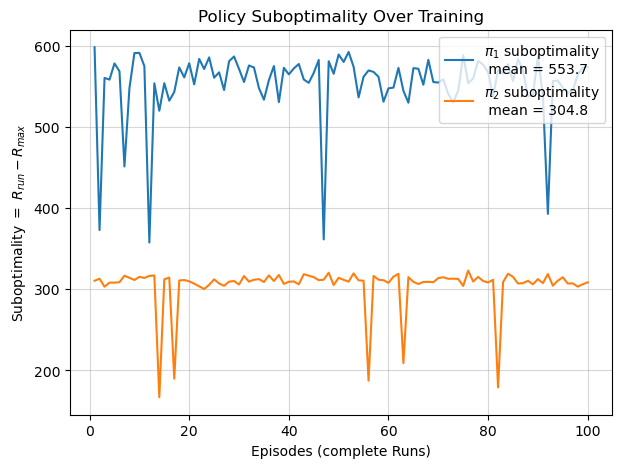

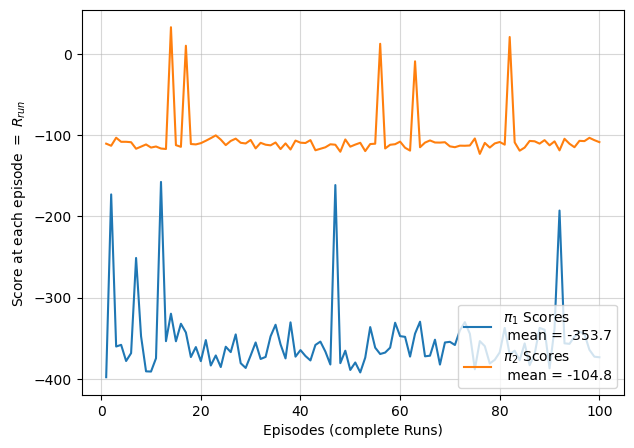

In [24]:
# Choose environment:

# env 3:  MountainCarContinuous,

env_name='MountainCarContinuous-v0'
env_oppo = gym.make(env_name)
baseline = baseline_MountainCar_continuous
# baseline = baseline_0
state_dim  = env_oppo.observation_space.shape[0]  # e.g. 2
action_dim = env_oppo.action_space.shape[0]       # e.g. 1
policy = PolicyContinuous(state_dim, action_dim).to(device)
target_score = 95 # TODO

# pass bounds into act (optional)
low, high = env_oppo.action_space.low, env_oppo.action_space.high


load_policies = False

# ── Hyperparams for OPPO ──
lr_oppo = 0.003 # learning rate for OPPO
n_episodes              = 200 # keep same “number of iterations” for fair comparison
max_t                   = 999  # cap on steps per episode
print_every             = 20   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99

seed_training_policies  = 42


# ── Instantiate the two policies & optimizers for OPPO ──

state_dim  = env_oppo.observation_space.shape[0]
action_dim = env_oppo.action_space.shape[0]

pi1_oppo = PolicyContinuous(
    state_dim,    # matches the __init__(self, state_dim, action_dim, …)
    action_dim
).to(device)
opt1_oppo    = torch.optim.Adam(pi1_oppo.parameters(), lr=lr_oppo)

pi2_oppo = PolicyContinuous(
    state_dim,    # matches the __init__(self, state_dim, action_dim, …)
    action_dim
).to(device)

opt2_oppo   = torch.optim.Adam(pi2_oppo.parameters(), lr=lr_oppo)


# ── Load the policies if you want to reuse them ──
if load_policies:
  pi1_oppo.load_state_dict(torch.load(f"pi1_oppo_{env_name}.pth"))


# ── Run the OPPO training ──
if not load_policies:
  # Training the policy:
  scores_oppo = OPPO_update(
      policy       = pi1_oppo,
      optimizer    = opt1_oppo,
      env          = env_oppo,
      baseline     = baseline,
      n_episodes   = n_episodes,
      max_t        = max_t,
      gamma        = gamma,      # you can reuse your PPO γ
      print_every  = print_every,
      early_stop   = False,
      seed = seed_training_policies,
      target_score = target_score,
      env_name= env_name,
      display_every = False
  )

# pi2_oppo.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))


seed_evaluation = 26
num_episodes = 100
pi1_mean_reward, pi1_reward = evaluate_policy(pi1_oppo, env_oppo, n_episodes=num_episodes)
pi2_mean_reward, pi2_reward = evaluate_policy(pi2_oppo, env_oppo, n_episodes=num_episodes)
print("Evaluations over", num_episodes, "episodes done for both policies")

plot_suboptimality(
    pi1_reward,
    pi2_reward,
    max_reward=200, # for CartPole-v0
)

plot_Scores(
    pi1_reward,
    pi2_reward,
)
